<h3> Задание 1.
Создание PINN с помощью библиотеки DeepXDE.

**Постановка задачи.** 
Решается смешанная обратная начально краевая задача для уравнения теплопроводности в прямоугольнике:
$\begin{equation}
    \begin{cases}
        \large{u_t = \frac{13}{10} \left( {u_{xx} + u_{yy}} \right) + \lambda e^{-\frac{3t}{2}}sin\left( {\frac{5x}{2}} \right) + \frac{4491e^{-\frac{3t}{2}} cos \left( {\frac{12y}{5}} \right)}{625}},\\
        \left( {x, y, t} \right) \in \left( {0, \pi} \right) \times \left( {-\pi, \pi} \right) \times \left( {0, 1} \right]\\
        \large{u\left( {x, y, 0} \right) = \frac{4sin\left( {\frac{5x}{2}} \right)}{5} + \frac{6cos\left( {\frac{12y}{5}} \right)}{5} + \frac{9}{10}},\\
        \large{u_x |_{x=0} = 2e^{-\frac{3t}{2}}}, \\
        \large{u_x |_{x=\pi} = 0}, \\
        \large{u |_{y=-\pi} = \frac{9}{10} + \frac{4e^{-\frac{3t}{2}} sin \left( {\frac{15x}{2}} \right)}{5} - 
        \frac{3e^{-\frac{3t}{2}}}{10} + \frac{3\sqrt{5}e^{-\frac{3t}{2}}}{10}}, \\
        \large{u |_{y=\pi} = \frac{9}{10} + \frac{4e^{-\frac{3t}{2}} sin \left( {\frac{15x}{2}} \right)}{5} - 
        \frac{3e^{-\frac{3t}{2}}}{10} + \frac{3\sqrt{5}e^{-\frac{3t}{2}}}{10}}.
    \end{cases}
\end{equation}$

Известны численные значения решения задачи (1) в некоторых точках в последний момент времени ($t=1$). Данные хранятся в файле.  
**Задание**: требуется определить неизвестную константу $\lambda$. Для решения данной обратной задачи необходимо создать и обучить свой PINN с помощью библиотеки DeepXDE.

**Шаги решения**  
1. Загрузить измеренные данные в момент времени $t = 1$ через numpy.load(). Ключи параметров: 'xyt' и 'u'.  
2. Определить геометрию области, временной интервал.
3. Задать функции уравнения, граничных и начальных условий.
4. Задать функции принадлежности границе/начальным условиям.
5. Создание dde-модели, описывающей систему уравнений.
6. Прогнать сеть с тремя различными начальными приближениямия неизвестной константы.

In [ ]:
#==============================
#-----------Imports------------
#==============================
import numpy as np
import torch
import deepxde as dde
import math
import pandas as pd


#==============================
#-----Backend selection--------
#==============================
dde.backend.set_default_backend("pytorch")
sin = torch.sin
cos = torch.cos
exp = torch.exp



#==============================
#------Device selection--------
#==============================
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
#==============================
#-----Извлечение данных--------
#==============================
measured_data = np.load('./var-20.npz', allow_pickle=True)
measured_domain = measured_data['xyt']
measured_u = measured_data['u']
measured_vals = dde.icbc.PointSetBC(measured_domain, measured_u, component=0)

In [4]:
#==============================
#-----Создание геометрии-------
#==============================
x0, x1 = 0, math.pi
y0, y1 = -math.pi, math.pi
T0, T1 = 0, 1
geometry = dde.geometry.Rectangle(xmin=[x0, y0], xmax=[x1, y1])
time_domain = dde.geometry.TimeDomain(T0, T1)
geomtime = dde.geometry.GeometryXTime(geometry, time_domain)

Переменная geomtime хранит все данные (узлы + время):
$$ geomtime =  \begin{bmatrix}
  x_1 & y_1 & t_1 \\
  \vdots & \ddots & \vdots \\
  x_n & y_n & t_n
\end{bmatrix} $$  
В качестве стартового приближения будут взяты три значения $\lambda = \left\{ {-5.0,\; 5.2,\; 20} \right\}$ 

In [5]:
const_lambda = dde.Variable(-5.0)  # Коэффициент, который мы хотим откалибровать

In [6]:
#==============================
#------Задание уравнения,------
#-----граничных и начальных----
#-----------условий------------
#==============================
# Здесь domain = geomtime
# x[:, 0:1] вместо x[:, 0] - чтобы сохранить размерность результата [n] x [1] вместо [n]
# Невязка уравнения теплопроводности
def pde(domain: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    u_xx = dde.grad.hessian(u, domain, i = 0, j = 0)
    u_yy = dde.grad.hessian(u, domain, i = 1, j = 1)
    u_t = dde.grad.jacobian(u, domain, j = 2)

    return ((u_t - 1.3 * (u_xx + u_yy))
            - const_lambda * exp(-3 * domain[:, 2:3] / 2)
            * sin(5 * domain[:, 0:1] / 2)
            - (4491 * exp(-3 * domain[:, 2:3] / 2)
            * cos(12 * domain[:, 1:2] / 5)
            / 625))

In [ ]:
# Определяем начальные условия
def initial_cond_func(domain):
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1]
        y = domain[:, 1:2]
    # Convert to numpy array to CUDA tensor
    else:
        x = torch.from_numpy(domain[:, 0:1]).to(device)
        y = torch.from_numpy(domain[:, 1:2]).to(device)
    return (4 * sin(5 * x / 2) / 5
            + 6 * cos(12 * y / 5) / 5
            + 0.9)



# Определяем уравнения для краевых условий в прямоугольнике.
# Левая и нижняя границы - со знаком минус(-1 во внешней нормали)
def left_boundary_func(domain):
    if (isinstance(domain, torch.Tensor)):
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        t = torch.from_numpy(domain[:, 2:3]).to(device)

    return -2 * exp(-3 * t / 2)

def right_boundary_func(domain):
    return 0

def low_boundary_func(domain):
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1]
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        x = torch.from_numpy(domain[:, 0:1]).to(device)
        t = torch.from_numpy(domain[:, 2:3]).to(device)
    return (-(0.9 + 0.2 * exp(-3 * t / 2)
            * (4 * sin(5 * x / 2) - 1.5 + 1.5 * math.sqrt(5))))

def top_boundary_func(domain):
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1]
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        x = torch.from_numpy(domain[:, 0:1]).to(device)
        t = torch.from_numpy(domain[:, 2:3]).to(device)
    return (0.9 + 0.2 * exp(-3 * t / 2)
            * (4 * sin(5. * x / 2) - 1.5 + 1.5 * math.sqrt(5)))

In [8]:
#==============================
#---------Определение----------
#--------принадлежности -------
#--------границе области-------
#==============================
def is_on_left_bound(point, on_boundary):
    return on_boundary and dde.utils.isclose(point[0], x0)

def is_on_right_bound(point, on_boundary):
    return on_boundary and dde.utils.isclose(point[0], x1)

def is_on_low_bound(point, on_boundary):
    return on_boundary and dde.utils.isclose(point[1], y0)

def is_on_top_bound(point, on_boundary):
    return on_boundary and dde.utils.isclose(point[1], y1)

def is_initial_cond(point, on_initial):
    return on_initial and dde.utils.isclose(point[2], T0)


In [9]:
#==============================
#-------Создание модели--------
#-----dde-системы уравнений----
#==============================
bc_left = dde.NeumannBC(geomtime, left_boundary_func, is_on_left_bound)
bc_right = dde.NeumannBC(geomtime, right_boundary_func, is_on_right_bound)
bc_low = dde.NeumannBC(geomtime, low_boundary_func, is_on_low_bound)
bc_top = dde.NeumannBC(geomtime, top_boundary_func, is_on_top_bound)
ic = dde.IC(geomtime, initial_cond_func, is_initial_cond)


data = dde.data.TimePDE(geomtime, pde, [bc_left, bc_right, bc_low, bc_top, ic, measured_vals],
                        num_domain=2800, num_boundary=1000, num_initial=2500,
                        anchors=measured_domain, num_test=3000)

Будет использоваться следующая архитектура полносвязной нейронной сети (FNN, Feedforward Neural Network). 
Входной слой - 3 нейрона (x, y, t), далее 5 промежуточных скрытых слоев, в каждом из которых по 50 нейронов, выходной слой - один нейрон(наша предполагаемая константа). В качестве функции активации рассматривается гиперболический тангенс (Tanh).

In [10]:
#==============================
#---------Архитектура----------
#--------нейронной сети--------
#==============================
layer_size = [3] + [50] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"

In [ ]:
#==============================
#-------Первый прогон----------
#--------нейронной сети--------
#==============================
const_lambda = dde.Variable(-30.0)  # Коэффициент, который мы хотим откалибровать

constants_vals = [[0.001, 50000], [0.0001, 10000], [0.00001, 5000]]


# Init model
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=1000) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)

for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable])


print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000336 s

Training model...

0         [3.67e+00, 1.03e+00, 2.38e-03, 1.48e+00, 1.28e+00, 2.78e+00, 1.61e+00]    [1.11e+01, 1.03e+00, 2.38e-03, 1.48e+00, 1.28e+00, 2.78e+00, 1.61e+00]    []  
0 [-5.00e+00]
100       [6.26e-01, 6.49e-02, 1.10e-02, 4.42e-02, 6.42e-02, 3.45e-01, 1.67e-01]    [3.48e+00, 6.49e-02, 1.10e-02, 4.42e-02, 6.42e-02, 3.45e-01, 1.67e-01]    []  
200       [2.24e-01, 1.67e-02, 4.44e-02, 3.35e-02, 5.88e-02, 1.57e-01, 1.30e-01]    [2.88e+00, 1.67e-02, 4.44e-02, 3.35e-02, 5.88e-02, 1.57e-01, 1.30e-01]    []  
300       [1.77e-01, 1.55e-02, 1.97e-02, 8.24e-03, 4.15e-02, 8.18e-02, 1.11e-01]    [2.02e+00, 1.55e-02, 1.97e-02, 8.24e-03, 4.15e-02, 8.18e-02, 1.11e-01]    []  
400       [1.17e-01, 6.27e-03, 6.16e-03, 3.00e-03, 1.50e-02, 3.97e-02, 8.92e-02]    [1.96e+00, 6.27e-03, 6.16e-03, 3.00e-03, 1.50e-02, 3.97e-02, 8.92e-02]    []  
500       [1.12e-01, 6.45e-03, 4.89e-03, 2.13e-03, 1.21e-02, 2.79e-02, 7.60e-02]    [1.82e+00, 6.45e-03, 4

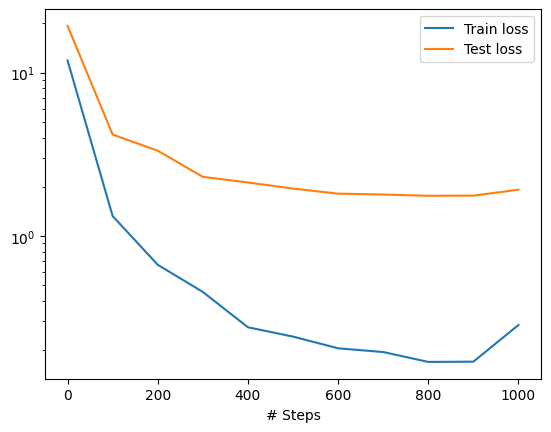

In [44]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(-5.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.01, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=1000) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000183 s

Training model...

0         [3.02e+00, 6.95e-01, 9.42e-03, 1.21e+00, 1.14e+00, 2.12e+00, 1.25e+00]    [8.65e+00, 6.95e-01, 9.42e-03, 1.21e+00, 1.14e+00, 2.12e+00, 1.25e+00]    []  
0 [2.00e+00]
100       [2.22e-01, 1.58e-02, 4.85e-03, 4.72e-02, 6.88e-02, 3.06e-01, 1.23e-01]    [9.26e-01, 1.58e-02, 4.85e-03, 4.72e-02, 6.88e-02, 3.06e-01, 1.23e-01]    []  
100 [1.24e+00]
200       [1.74e-01, 1.31e-02, 1.54e-02, 5.19e-02, 7.34e-02, 2.50e-01, 9.16e-02]    [1.26e+00, 1.31e-02, 1.54e-02, 5.19e-02, 7.34e-02, 2.50e-01, 9.16e-02]    []  
200 [1.03e+00]
300       [1.06e-01, 4.91e-03, 2.01e-02, 1.45e-02, 2.83e-02, 1.44e-01, 6.46e-02]    [1.41e+00, 4.91e-03, 2.01e-02, 1.45e-02, 2.83e-02, 1.44e-01, 6.46e-02]    []  
300 [9.76e-01]
400       [1.42e-01, 4.97e-03, 1.87e-02, 1.97e-02, 1.38e-02, 9.32e-02, 5.86e-02]    [1.54e+00, 4.97e-03, 1.87e-02, 1.97e-02, 1.38e-02, 9.32e-02, 5.86e-02]    []  
400 [9.74e-01]
500       [1.22e-01, 4.69e-03, 1.16e-02, 1.38e-

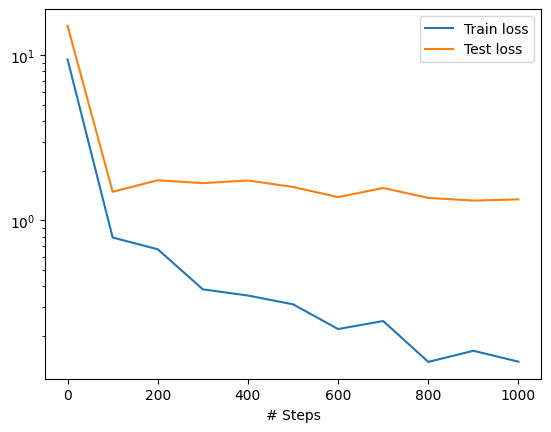

In [46]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(2.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.01, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000600 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.83e+00, 7.03e-01, 8.07e-03, 1.16e+00, 1.21e+00, 2.14e+00, 1.05e+00]    [8.32e+00, 7.03e-01, 8.07e-03, 1.16e+00, 1.21e+00, 2.14e+00, 1.05e+00]    []  
0 [1.56e+00]
100 [1.55e+00]
200 [1.54e+00]
300 [1.53e+00]
400 [1.53e+00]
500 [1.52e+00]
600 [1.51e+00]
700 [1.50e+00]
800 [1.49e+00]
900 [1.49e+00]
1000      [5.10e-01, 4.20e-02, 2.48e-02, 6.45e-02, 4.54e-02, 4.50e-01, 1.14e-01]    [1.77e+00, 4.20e-02, 2.48e-02, 6.45e-02, 4.54e-02, 4.50e-01, 1.14e-01]    []  
1000 [1.48e+00]
1100 [1.48e+00]
1200 [1.47e+00]
1300 [1.47e+00]
1400 [1.47e+00]
1500 [1.46e+00]
1600 [1.46e+00]
1700 [1.46e+00]
1800 [1.45e+00]
1900 [1.45e+00]
2000      [1.77e-01, 1.26e-02, 1.66e-02, 1.91e-02, 5.38e-02, 1.99e-01, 1.00e-01]    [9.60e-01, 1.26e-02, 1.66e-02, 1.91e-02, 5.38e-

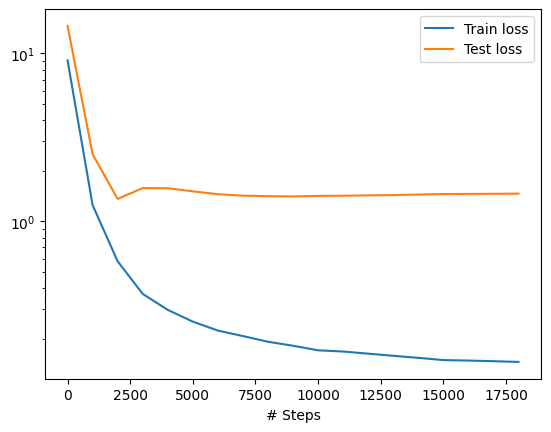

In [47]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(1.56)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.0001, 10000], [0.00001, 5000], [0.000001, 3000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable])

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000353 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [4.59e+01, 1.13e+00, 1.22e-02, 1.06e+00, 9.81e-01, 3.08e+00, 1.44e+00]    [1.34e+02, 1.13e+00, 1.22e-02, 1.06e+00, 9.81e-01, 3.08e+00, 1.44e+00]    []  
0 [-3.00e+01]
100       [1.90e+01, 6.86e-01, 1.71e-01, 9.74e-01, 1.25e+00, 1.24e+00, 1.01e-01]    [7.14e+01, 6.86e-01, 1.71e-01, 9.74e-01, 1.25e+00, 1.24e+00, 1.01e-01]    []  
200       [7.95e+00, 3.56e-01, 9.64e-02, 3.50e-01, 7.44e-01, 1.25e+00, 2.31e-01]    [4.15e+01, 3.56e-01, 9.64e-02, 3.50e-01, 7.44e-01, 1.25e+00, 2.31e-01]    []  
300       [6.55e+00, 8.29e-01, 4.28e-05, 1.18e+00, 1.18e+00, 1.10e+00, 5.80e-02]    [1.97e+01, 8.29e-01, 4.28e-05, 1.18e+00, 1.18e+00, 1.10e+00, 5.80e-02]    []  
400       [3.59e+00, 8.30e-01, 1.39e-13, 1.18e+00, 1.20e+00, 1.04e+00, 6.10e-02]    [1.09e+01, 8.30

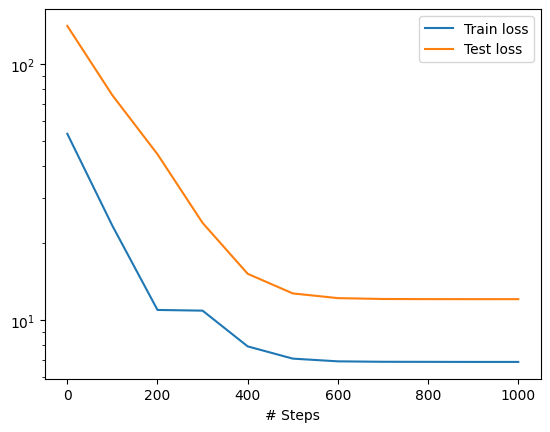

In [48]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(-30.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.1, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=1000) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000384 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [4.72e+01, 1.14e+00, 1.47e-02, 1.06e+00, 8.40e-01, 3.30e+00, 2.03e+00]    [1.36e+02, 1.14e+00, 1.47e-02, 1.06e+00, 8.40e-01, 3.30e+00, 2.03e+00]    []  
0 [3.00e+01]
100       [2.36e+01, 8.30e-01, 2.55e-16, 1.18e+00, 1.20e+00, 1.04e+00, 7.69e-02]    [6.85e+01, 8.30e-01, 2.55e-16, 1.18e+00, 1.20e+00, 1.04e+00, 7.69e-02]    []  
200       [1.12e+01, 8.30e-01, 1.39e-16, 1.18e+00, 1.20e+00, 1.04e+00, 6.08e-02]    [3.25e+01, 8.30e-01, 1.39e-16, 1.18e+00, 1.20e+00, 1.04e+00, 6.08e-02]    []  
300       [5.53e+00, 8.30e-01, 1.40e-16, 1.18e+00, 1.20e+00, 1.04e+00, 6.10e-02]    [1.62e+01, 8.30e-01, 1.40e-16, 1.18e+00, 1.20e+00, 1.04e+00, 6.10e-02]    []  
400       [3.40e+00, 8.30e-01, 1.41e-16, 1.18e+00, 1.20e+00, 1.04e+00, 6.10e-02]    [1.01e+01, 8.30e

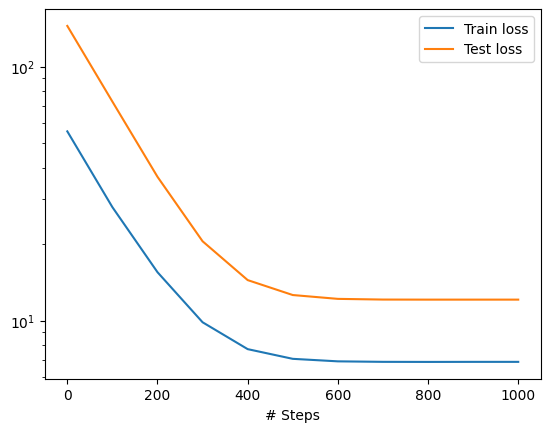

In [49]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(30.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.1, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=1000) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000457 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.78e+00, 1.88e+00, 3.39e-02, 1.50e+00, 1.31e+00, 4.41e+00, 2.18e+00]    [8.38e+00, 1.88e+00, 3.39e-02, 1.50e+00, 1.31e+00, 4.41e+00, 2.18e+00]    []  
0 [2.00e+00]
100       [2.76e+00, 1.38e+00, 2.15e-02, 1.36e+00, 1.37e+00, 3.42e+00, 1.31e+00]    [8.31e+00, 1.38e+00, 2.15e-02, 1.36e+00, 1.37e+00, 3.42e+00, 1.31e+00]    []  
100 [2.00e+00]
200       [2.75e+00, 1.04e+00, 1.19e-02, 1.25e+00, 1.42e+00, 2.70e+00, 7.39e-01]    [8.28e+00, 1.04e+00, 1.19e-02, 1.25e+00, 1.42e+00, 2.70e+00, 7.39e-01]    []  
200 [2.00e+00]
300       [2.76e+00, 7.90e-01, 5.92e-03, 1.15e+00, 1.44e+00, 2.20e+00, 3.95e-01]    [8.28e+00, 7.90e-01, 5.92e-03, 1.15e+00, 1.44e+00, 2.20e+00, 3.95e-01]    []  
300 [2.00e+00]
400       [2.77e+00, 6.11e-01, 2.73e-03, 1.06e+00, 1.43

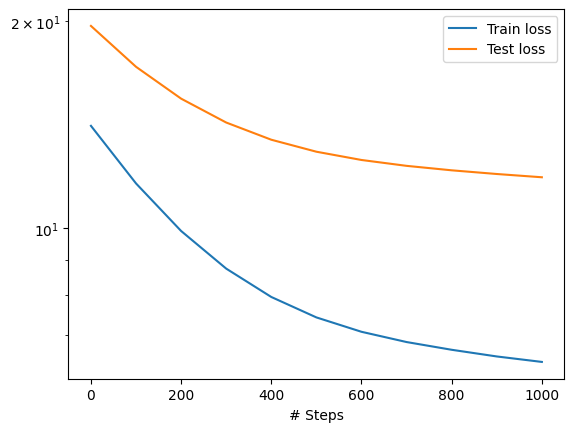

In [51]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(2.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.00001, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000196 s

Training model...

0         [2.80e+00, 3.18e-01, 4.66e-02, 1.12e+00, 1.44e+00, 1.69e+00, 6.53e-01]    [8.17e+00, 3.18e-01, 4.66e-02, 1.12e+00, 1.44e+00, 1.69e+00, 6.53e-01]    []  
0 [1.00e+00]
100       [2.59e+00, 2.02e-01, 9.72e-03, 6.75e-01, 8.79e-01, 1.32e+00, 1.63e-01]    [7.80e+00, 2.02e-01, 9.72e-03, 6.75e-01, 8.79e-01, 1.32e+00, 1.63e-01]    []  
100 [9.91e-01]
200       [2.29e+00, 1.80e-01, 2.69e-02, 3.97e-01, 3.49e-01, 1.17e+00, 1.44e-01]    [6.94e+00, 1.80e-01, 2.69e-02, 3.97e-01, 3.49e-01, 1.17e+00, 1.44e-01]    []  
200 [9.83e-01]
300       [1.86e+00, 1.91e-01, 4.57e-02, 2.37e-01, 1.25e-01, 1.13e+00, 1.63e-01]    [5.89e+00, 1.91e-01, 4.57e-02, 2.37e-01, 1.25e-01, 1.13e+00, 1.63e-01]    []  
300 [9.76e-01]
400       [1.51e+00, 1.71e-01, 3.14e-02, 1.70e-01, 7.33e-02, 1.10e+00, 1.71e-01]    [5.10e+00, 1.71e-01, 3.14e-02, 1.70e-01, 7.33e-02, 1.10e+00, 1.71e-01]    []  
400 [9.68e-01]
500       [1.13e+00, 1.26e-01, 2.03e-02, 1.21e-

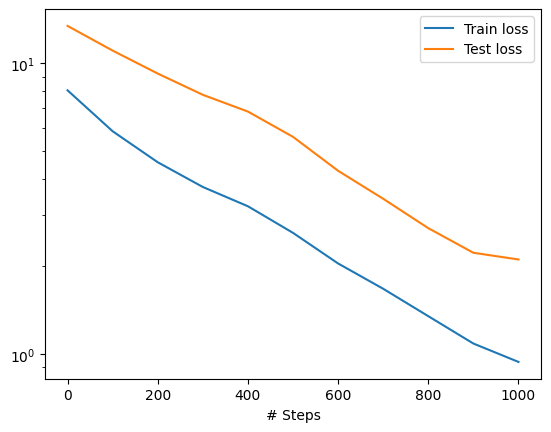

In [53]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(1.0)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.0001, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000154 s

Training model...

0         [2.59e+00, 6.72e-01, 8.64e-04, 1.29e+00, 1.35e+00, 2.21e+00, 7.87e-01]    [7.87e+00, 6.72e-01, 8.64e-04, 1.29e+00, 1.35e+00, 2.21e+00, 7.87e-01]    []  
0 [9.30e-01]
100       [2.55e+00, 1.73e-01, 5.45e-03, 8.64e-01, 9.62e-01, 1.35e+00, 1.40e-01]    [7.72e+00, 1.73e-01, 5.45e-03, 8.64e-01, 9.62e-01, 1.35e+00, 1.40e-01]    []  
100 [9.21e-01]
200       [2.58e+00, 1.41e-01, 1.16e-02, 6.81e-01, 5.80e-01, 1.21e+00, 9.96e-02]    [7.66e+00, 1.41e-01, 1.16e-02, 6.81e-01, 5.80e-01, 1.21e+00, 9.96e-02]    []  
200 [9.13e-01]
300       [2.46e+00, 1.41e-01, 3.59e-02, 3.27e-01, 2.24e-01, 1.15e+00, 1.17e-01]    [7.38e+00, 1.41e-01, 3.59e-02, 3.27e-01, 2.24e-01, 1.15e+00, 1.17e-01]    []  
300 [9.06e-01]
400       [1.99e+00, 1.48e-01, 4.64e-02, 1.61e-01, 7.14e-02, 1.15e+00, 1.71e-01]    [6.43e+00, 1.48e-01, 4.64e-02, 1.61e-01, 7.14e-02, 1.15e+00, 1.71e-01]    []  
400 [8.97e-01]
500       [1.55e+00, 1.30e-01, 3.03e-02, 1.24e-

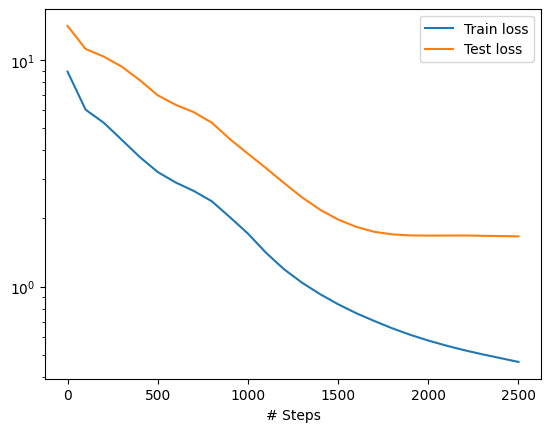

In [55]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(0.93)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.0001, 2500]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000162 s

Training model...

0         [2.65e+00, 7.35e-01, 1.12e-03, 1.17e+00, 1.17e+00, 2.21e+00, 1.01e+00]    [7.92e+00, 7.35e-01, 1.12e-03, 1.17e+00, 1.17e+00, 2.21e+00, 1.01e+00]    []  
0 [7.90e-01]
100       [2.62e+00, 5.57e-01, 4.14e-03, 1.11e+00, 1.23e+00, 1.89e+00, 6.57e-01]    [7.88e+00, 5.57e-01, 4.14e-03, 1.11e+00, 1.23e+00, 1.89e+00, 6.57e-01]    []  
100 [7.89e-01]
200       [2.60e+00, 4.27e-01, 7.24e-03, 1.05e+00, 1.26e+00, 1.69e+00, 4.35e-01]    [7.85e+00, 4.27e-01, 7.24e-03, 1.05e+00, 1.26e+00, 1.69e+00, 4.35e-01]    []  
200 [7.88e-01]
300       [2.59e+00, 3.40e-01, 9.33e-03, 9.88e-01, 1.26e+00, 1.56e+00, 3.09e-01]    [7.83e+00, 3.40e-01, 9.33e-03, 9.88e-01, 1.26e+00, 1.56e+00, 3.09e-01]    []  
300 [7.87e-01]
400       [2.59e+00, 2.88e-01, 1.02e-02, 9.34e-01, 1.24e+00, 1.50e+00, 2.49e-01]    [7.81e+00, 2.88e-01, 1.02e-02, 9.34e-01, 1.24e+00, 1.50e+00, 2.49e-01]    []  
400 [7.86e-01]
500       [2.58e+00, 2.58e-01, 1.01e-02, 8.88e-

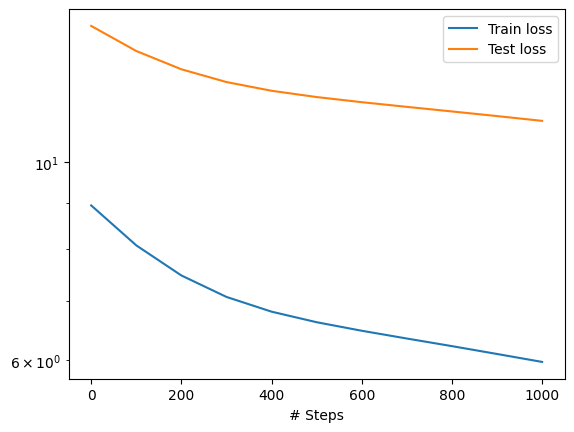

In [58]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(0.79)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.00001, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 9.513742 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.66e+00, 1.15e+00, 1.07e-02, 1.40e+00, 1.09e+00, 3.09e+00, 1.88e+00]    [7.95e+00, 1.15e+00, 1.07e-02, 1.40e+00, 1.09e+00, 3.09e+00, 1.88e+00]    []  
0 [3.00e-01]
100       [2.61e+00, 7.88e-01, 3.79e-03, 1.28e+00, 1.12e+00, 2.41e+00, 1.17e+00]    [7.86e+00, 7.88e-01, 3.79e-03, 1.28e+00, 1.12e+00, 2.41e+00, 1.17e+00]    []  
100 [2.99e-01]
200       [2.58e+00, 5.38e-01, 6.28e-04, 1.18e+00, 1.16e+00, 1.96e+00, 7.09e-01]    [7.80e+00, 5.38e-01, 6.28e-04, 1.18e+00, 1.16e+00, 1.96e+00, 7.09e-01]    []  
200 [2.98e-01]
300       [2.56e+00, 3.74e-01, 1.15e-04, 1.09e+00, 1.18e+00, 1.68e+00, 4.35e-01]    [7.77e+00, 3.74e-01, 1.15e-04, 1.09e+00, 1.18e+00, 1.68e+00, 4.35e-01]    []  
300 [2.97e-01]
400       [2.57e+00, 2.78e-01, 8.06e-04, 1.02e+00, 1.18

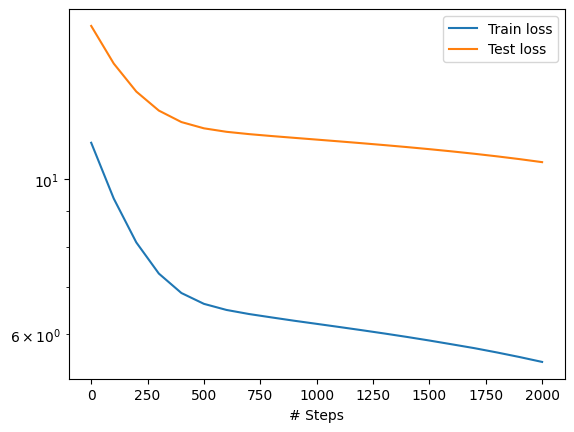

In [11]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(0.3)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.00001, 2000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000342 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.63e+00, 1.44e+00, 3.67e-03, 1.24e+00, 1.14e+00, 3.36e+00, 1.41e+00]    [8.01e+00, 1.44e+00, 3.67e-03, 1.24e+00, 1.14e+00, 3.36e+00, 1.41e+00]    []  
0 [-1.50e+00]
100       [1.15e+00, 1.65e-01, 3.56e-02, 1.87e-01, 5.33e-02, 1.08e+00, 1.93e-01]    [4.24e+00, 1.65e-01, 3.56e-02, 1.87e-01, 5.33e-02, 1.08e+00, 1.93e-01]    []  
100 [-1.40e+00]
200       [4.36e-01, 5.93e-02, 2.45e-02, 6.33e-02, 7.36e-02, 3.73e-01, 1.84e-01]    [1.83e+00, 5.93e-02, 2.45e-02, 6.33e-02, 7.36e-02, 3.73e-01, 1.84e-01]    []  
200 [-1.31e+00]
300       [2.74e-01, 3.89e-02, 1.56e-02, 3.23e-02, 6.03e-02, 2.97e-01, 1.20e-01]    [1.56e+00, 3.89e-02, 1.56e-02, 3.23e-02, 6.03e-02, 2.97e-01, 1.20e-01]    []  
300 [-1.21e+00]
400       [2.15e-01, 3.32e-02, 1.37e-02, 2.73e-02, 

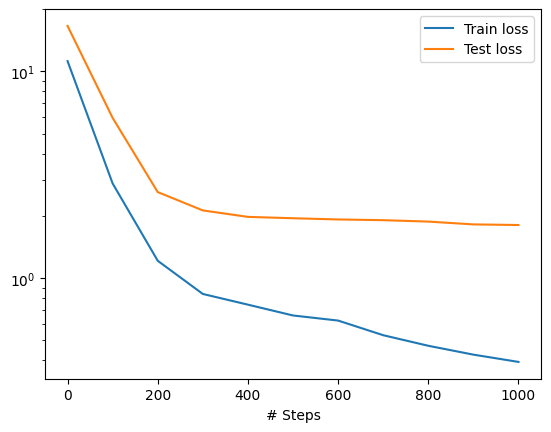

In [12]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(-1.5)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.001, 1000]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000553 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.89e+00, 1.56e+00, 8.83e-03, 1.22e+00, 7.44e-01, 3.89e+00, 3.27e+00]    [8.32e+00, 1.56e+00, 8.83e-03, 1.22e+00, 7.44e-01, 3.89e+00, 3.27e+00]    []  
0 [-7.40e-01]
100       [2.76e+00, 1.08e+00, 6.54e-03, 1.12e+00, 8.11e-01, 2.92e+00, 2.07e+00]    [8.10e+00, 1.08e+00, 6.54e-03, 1.12e+00, 8.11e-01, 2.92e+00, 2.07e+00]    []  
100 [-7.39e-01]
200       [2.67e+00, 7.41e-01, 7.05e-03, 1.04e+00, 8.73e-01, 2.25e+00, 1.24e+00]    [7.94e+00, 7.41e-01, 7.05e-03, 1.04e+00, 8.73e-01, 2.25e+00, 1.24e+00]    []  
200 [-7.38e-01]
300       [2.61e+00, 5.11e-01, 9.00e-03, 9.79e-01, 9.25e-01, 1.83e+00, 7.19e-01]    [7.84e+00, 5.11e-01, 9.00e-03, 9.79e-01, 9.25e-01, 1.83e+00, 7.19e-01]    []  
300 [-7.37e-01]
400       [2.57e+00, 3.65e-01, 1.10e-02, 9.27e-01, 

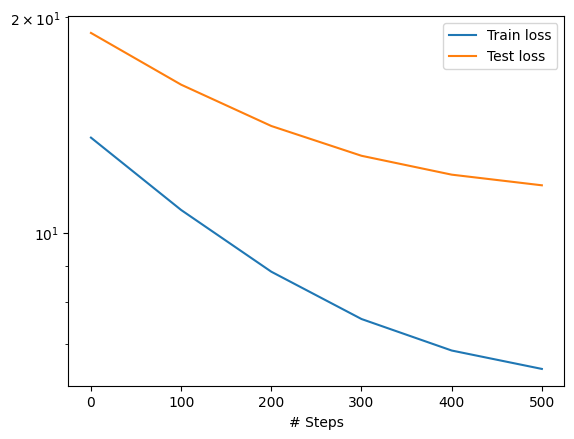

In [13]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(-0.74)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.00001, 500]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
net = dde.nn.FNN(layer_size, activation, initializer)

const_lambda = dde.Variable(-0.97)  # Коэффициент, который мы хотим откалибровать

# "Схема" прогона сети
constants_vals = [[0.000001, 00]]
# Init model
model = dde.Model(data, net) # входные данные и архитектура
variable = dde.callbacks.VariableValue(const_lambda, period=100) # вывод каждые 1000 итераций
pde_resampler = dde.callbacks.PDEPointResampler(period=800)


for c_v in constants_vals:
    model.compile("adam", lr=c_v[0], external_trainable_variables=const_lambda)
    losshistory, train_state = model.train(iterations=c_v[1], callbacks=[pde_resampler,variable], display_every=100)

print(const_lambda)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)